In [1]:
import pandas as pd
import make_datasets as src

C:\Users\elina.filatova_neuro\Desktop\data_base\make_datasets\.env


In [2]:
connection = src.connect_maria_db()

In [3]:
query = """select a.id as activity_id,
a.code, at.name, ar.id as area_id, art.full_name as area_name, aa.weight as 'area_weight', 
aco.configuration_option_id, co.identifier as 'configuration_option', 
with_values, cov.id as 'value_id', cov.identifier as 'value_identifier', at.keywords, at.description
from nup_activity a
join nup_activity_translation at on at.translatable_id = a.id
join nup_activity_area aa on aa.activity_id = a.id
join nup_area ar on ar.id = aa.area_id
join nup_area_translation art on art.translatable_id = ar.id
join nup_activity_configuration_option aco on aco.activity_id = a.id
join nup_configuration_option co on co.id = aco.configuration_option_id
left join nup_configuration_option_value cov on cov.configuration_option_id = co.id
where a.enabled = 1
and (a.format_id = 1 or format_id is null)
and at.locale = 'es_ES' and art.locale = 'es_ES'
order by aa.activity_id, co.id;"""



data = pd.read_sql_query(query, connection)
activities = data[["activity_id", "code", "name", "keywords", "description"]].drop_duplicates()
activities = activities[~activities["code"].str.startswith("A_")]

In [4]:
activities

,activity_id,code,name,keywords,description
0,351,ER1,Consecuencias,funciones ejecutivas razonamiento valor ecológ...,Determinar las consecuencias posibles de deter...
4,352,ASE3,Búsqueda de estímulos consecutivos,atención selectiva heminegligencia búsqueda se...,Buscar entre un conjunto de estímulos la clave...
13,353,ASU1,Encontrar los números que faltan,atención sostenida números faltan encontrar ta...,Encontrar en una tabla llena de números aquell...
15,354,GV1,Encontrar el color igual,gnosias visuales percepción identificar colore...,Seleccionar el color exactamente igual al modelo.
22,355,LD1,Identificar sonidos en nombres de imágenes,lenguaje discriminacion fonológica imágenes im...,Identificar ciertos sonidos en los nombres de ...
...,...,...,...,...,...
5696,1933,SG-ME39-A,Recuerda los nombres (audio),memorizar aprender recordar memorización apren...,Memorizar y relacionar los nombres escuchados ...
5705,1936,SG-ME39-K,Aprende los nombres (audio),escuchar nombres memorizar aprender recordar m...,Memorizar y relacionar los nombres escuchados ...
5714,1939,SG-VSR31-A,Escalas,atención heminegligencia escalas ubicar ubicac...,"Localizar un número específico en una línea, u..."
5738,1942,SG-VSR30-A,Ángulos,habilidades visoespaciales relación espacial a...,Formar el ángulo indicado en base a la línea d...


In [5]:
activities = data[["activity_id", "code", "name", "keywords", "description"]].drop_duplicates()
activities = activities[~activities["code"].str.startswith("A_")]
# activities["keywords"] = activities["keywords"].str.split(" ")

### 1. SentenceTransformer

In [6]:
from sentence_transformers import SentenceTransformer, util
df = activities
def combine_text(row):
    # keywords = " ".join(row["keywords"]) if isinstance(row["keywords"], list) and row["keywords"] else ""
    return f"{row['name']} {row['keywords']} {row["description"]}".strip()

df["text"] = df.apply(combine_text, axis=1)
activity_texts = df["text"].tolist()

In [7]:
df["activity_id"].nunique() == df.shape[0]

True

In [8]:
# model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = model.encode(activity_texts, convert_to_tensor=True)

In [9]:
activity_texts[:2]

['Consecuencias funciones ejecutivas razonamiento valor ecológico validez ecológica predictivo consecuencias situaciones posibilidades reacciones reacción situación vida real diaria sentido práctico razonar problemas realidad Determinar las consecuencias posibles de determinadas situaciones.',
 'Búsqueda de estímulos consecutivos atención selectiva heminegligencia búsqueda selección estímulos consecutivos seguidos barridos buscar encontrar Ambas Individual Fichas Buscar entre un conjunto de estímulos la clave dada.']

In [10]:
def search_activity(query, df, embeddings, top_k=5):
    query_embedding = model.encode(query, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(query_embedding, embeddings)[0]
    top_results = cosine_scores.argsort(descending=True)[:top_k]
    return df.iloc[top_results]

In [11]:
embeddings

tensor([[ 0.0561,  0.0580,  0.0034,  ...,  0.2960, -0.1267, -0.0285],
        [-0.1284,  0.0175, -0.0341,  ...,  0.5273, -0.2332,  0.1479],
        [-0.1374,  0.1851, -0.1540,  ...,  0.1749, -0.1744,  0.0916],
        ...,
        [-0.0624, -0.0245,  0.0698,  ...,  0.2992, -0.4209,  0.0646],
        [ 0.1719, -0.1627,  0.1091,  ...,  0.4697, -0.5065,  0.1223],
        [ 0.1325,  0.2481, -0.2142,  ...,  0.2614, -0.1369,  0.1657]])

In [12]:
query = 'resolver problemas con mala memoria'
query_embedding = model.encode(query, convert_to_tensor=True)
cosine_scores = util.pytorch_cos_sim(query_embedding, embeddings)[0]

In [13]:
cosine_scores

tensor([0.2189, 0.2963, 0.3771, 0.0932, 0.1289, 0.0301, 0.2861, 0.1754, 0.1328,
        0.1980, 0.2910, 0.1724, 0.1725, 0.2709, 0.4949, 0.3076, 0.2358, 0.2494,
        0.0759, 0.2352, 0.2461, 0.1873, 0.2814, 0.2545, 0.2279, 0.2327, 0.1271,
        0.1709, 0.0787, 0.1602, 0.2981, 0.3159, 0.1180, 0.2034, 0.1113, 0.3208,
        0.4756, 0.4787, 0.4878, 0.3810, 0.3178, 0.2718, 0.4524, 0.4986, 0.1960,
        0.1314, 0.3478, 0.4003, 0.3638, 0.1379, 0.3261, 0.3041, 0.2166, 0.4972,
        0.3925, 0.4846, 0.2104, 0.4890, 0.5051, 0.3778, 0.3577, 0.4188, 0.2687,
        0.5203, 0.3846, 0.3798, 0.4227, 0.3556, 0.3192, 0.3881, 0.3410, 0.4528,
        0.2342, 0.4660, 0.4400, 0.3418, 0.3215, 0.2527, 0.3510, 0.4828, 0.4719,
        0.2703, 0.5049, 0.3526, 0.2003, 0.3237, 0.4352, 0.3070, 0.3371, 0.2665,
        0.2040, 0.3455, 0.4949, 0.3127, 0.2766, 0.5032, 0.4824, 0.3604, 0.3705,
        0.2434, 0.3809, 0.4049, 0.1723, 0.3058, 0.3398, 0.3889, 0.3126, 0.2890,
        0.4734, 0.2897, 0.2973, 0.1364, 

In [15]:
results = search_activity("resolver problemas con mala memoria", df, embeddings, top_k=10)
results

,activity_id,code,name,keywords,description,text
3648,1284,ME73,Yincana de obstáculos,memoria episódica funciones ejecutivas planifi...,Memorizar una serie de obstáculos y luego traz...,Yincana de obstáculos memoria episódica funcio...
4302,1478,ME13,Obstáculos en la carretera,memoria episódica funciones ejecutivas planifi...,Memorizar una serie de obstáculos y luego traz...,Obstáculos en la carretera memoria episódica f...
711,744,J_venPerm_sin,Ventanas iluminadas (tiempo de memorización li...,memoria episódica visual inmediata demorada co...,Esta actividad consiste en memorizar la posici...,Ventanas iluminadas (tiempo de memorización li...
4631,1576,J_memory_names_adult,Recuerda los nombres (texto),memorizar aprender recordar memorización apren...,Memorizar el nombre de las personas mostradas.,Recuerda los nombres (texto) memorizar aprende...
5678,1927,SG-ME40-A,Recuerda los nombres (texto),memorizar aprender recordar memorización apren...,Memorizar el nombre de las personas mostradas.,Recuerda los nombres (texto) memorizar aprende...
3910,1389,ME5,Memorización por formación de dibujo,memoria episódica recordar memorizar recuerdo ...,Recordar la posición de una serie de puntos al...,Memorización por formación de dibujo memoria e...
616,739,J_venPerm,Ventanas iluminadas,memoria episódica visual inmediata demorada co...,Esta actividad consiste en memorizar la posici...,Ventanas iluminadas memoria episódica visual i...
1001,765,GEWM12,Restas,funciones ejecutivas memoria trabajo operativa...,Esta actividad consiste en realizar una serie ...,Restas funciones ejecutivas memoria trabajo op...
1238,782,GEWM6,Sudoku,funciones ejecutivas memoria trabajo operativa...,Completar una matriz de números según las inst...,Sudoku funciones ejecutivas memoria trabajo op...
1680,822,J_topos_inf,Invasión de topos,memoria episódica trabajo operativa visuales a...,Esta actividad consiste en recordar el orden e...,Invasión de topos memoria episódica trabajo op...


In [20]:
results = search_activity("активности которые содержат фото кошек", df, embeddings, top_k=10)
results

,activity_id,code,name,keywords,description,text
5118,1773,SG-ME30-K,¿Dónde están los gatos?,visual inmediata demorada corto largo plazo se...,Memorizar la posición de diversos elementos pa...,¿Dónde están los gatos? visual inmediata demor...
3509,1247,AD_fotos,D Borra las fotos,AD_fotos investigación Arango Biocruces atenci...,Pulsar cada vez que aparezca la foto de un gat...,D Borra las fotos AD_fotos investigación Arang...
4194,1462,J_venPerm_sin_child,¿Dónde están los gatos?,visual inmediata demorada corto largo plazo se...,Esta actividad consiste en memorizar la posici...,¿Dónde están los gatos? visual inmediata demor...
3016,1116,ASE_fotos,SE Borra las fotos,ASE_fotos investigación Arango Biocruces atenc...,Pulsar cada vez que aparezca la foto indicada.,SE Borra las fotos ASE_fotos investigación Ara...
5124,1782,SG-ME31-K,¿Dónde están los gatos? (tiempo de memorizació...,visual inmediata demorada corto largo plazo se...,Memorizar la posición de diversos elementos pa...,¿Dónde están los gatos? (tiempo de memorizació...
3411,1207,AA_fotos,A Borra las fotos,AA_fotos investigación Arango Biocruces atenci...,Pulsar cada vez que aparezcan las fotos indica...,A Borra las fotos AA_fotos investigación Arang...
5057,1749,SG-ME36-K,Parejas de animales,episódica atención selectiva visual inmediata ...,Descubrir las parejas entre un conjunto de car...,Parejas de animales episódica atención selecti...
1505,804,GAPS67,Atrapa los ratones,atención velocidad procesamiento valor ecológi...,Contar el número de dibujos presentados.,Atrapa los ratones atención velocidad procesam...
1113,775,J_sumas,Suma de figuras,atención selectiva sostenida habilidades visoe...,Esta actividad consiste en imaginar y rellenar...,Suma de figuras atención selectiva sostenida h...
3000,1113,ASE_figuras,SE Figuras geométricas,ASE_figuras investigación Arango Biocruces ate...,Pulsar cada vez que aparezca la figura indicada.,SE Figuras geométricas ASE_figuras investigaci...


In [21]:
results = search_activity("actividades con las imagenes de gatos", df, embeddings, top_k=10)
results

,activity_id,code,name,keywords,description,text
5118,1773,SG-ME30-K,¿Dónde están los gatos?,visual inmediata demorada corto largo plazo se...,Memorizar la posición de diversos elementos pa...,¿Dónde están los gatos? visual inmediata demor...
3509,1247,AD_fotos,D Borra las fotos,AD_fotos investigación Arango Biocruces atenci...,Pulsar cada vez que aparezca la foto de un gat...,D Borra las fotos AD_fotos investigación Arang...
4194,1462,J_venPerm_sin_child,¿Dónde están los gatos?,visual inmediata demorada corto largo plazo se...,Esta actividad consiste en memorizar la posici...,¿Dónde están los gatos? visual inmediata demor...
3016,1116,ASE_fotos,SE Borra las fotos,ASE_fotos investigación Arango Biocruces atenc...,Pulsar cada vez que aparezca la foto indicada.,SE Borra las fotos ASE_fotos investigación Ara...
5124,1782,SG-ME31-K,¿Dónde están los gatos? (tiempo de memorizació...,visual inmediata demorada corto largo plazo se...,Memorizar la posición de diversos elementos pa...,¿Dónde están los gatos? (tiempo de memorizació...
3411,1207,AA_fotos,A Borra las fotos,AA_fotos investigación Arango Biocruces atenci...,Pulsar cada vez que aparezcan las fotos indica...,A Borra las fotos AA_fotos investigación Arang...
5057,1749,SG-ME36-K,Parejas de animales,episódica atención selectiva visual inmediata ...,Descubrir las parejas entre un conjunto de car...,Parejas de animales episódica atención selecti...
3000,1113,ASE_figuras,SE Figuras geométricas,ASE_figuras investigación Arango Biocruces ate...,Pulsar cada vez que aparezca la figura indicada.,SE Figuras geométricas ASE_figuras investigaci...
1113,775,J_sumas,Suma de figuras,atención selectiva sostenida habilidades visoe...,Esta actividad consiste en imaginar y rellenar...,Suma de figuras atención selectiva sostenida h...
3331,1183,AA_figuras,A Figuras geométricas,AA_figuras investigación Arango Biocruces aten...,Pulsar cada vez que aparezcan las figuras indi...,A Figuras geométricas AA_figuras investigación...


In [18]:
len(activity_texts), len(embeddings)

(337, 337)

In [19]:
stats = {}

for i,act_text in enumerate(activity_texts):
    stats[i] = len(act_text.split())

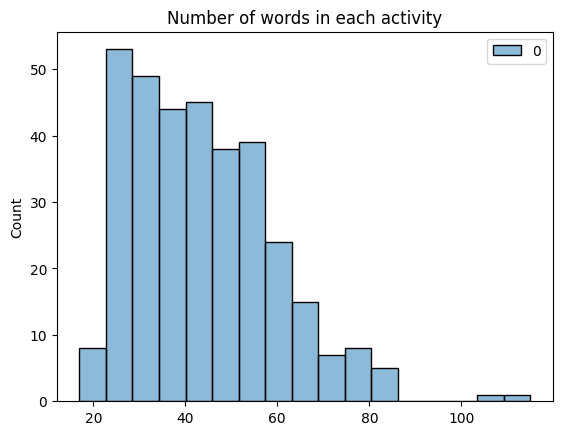

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt   
sns.histplot(stats.values())
plt.title("Number of words in each activity")
plt.show()

In [23]:
results = search_activity("mejorar memoria", df, embeddings, top_k=10)
results.head()

,activity_id,code,name,keywords,description,text
735,744,J_venPerm_sin,Ventanas iluminadas (tiempo de memorización li...,memoria episódica visual inmediata demorada co...,Esta actividad consiste en memorizar la posici...,Ventanas iluminadas (tiempo de memorización li...
4707,1576,J_memory_names_adult,Recuerda los nombres (texto),memorizar aprender recordar memorización apren...,Memorizar el nombre de las personas mostradas.,Recuerda los nombres (texto) memorizar aprende...
1551,809,GME71,Ordena los dibujos (tiempo de memorización libre),memoria episódica valor ecológico validez ecol...,Ordenar una serie de dibujos memorizados previ...,Ordena los dibujos (tiempo de memorización lib...
640,739,J_venPerm,Ventanas iluminadas,memoria episódica visual inmediata demorada co...,Esta actividad consiste en memorizar la posici...,Ventanas iluminadas memoria episódica visual i...
3986,1389,ME5,Memorización por formación de dibujo,memoria episódica recordar memorizar recuerdo ...,Recordar la posición de una serie de puntos al...,Memorización por formación de dibujo memoria e...
